# CSIS 4260 - Special Topics in Data Analytics

### Assignment 2 - Learning web scrapping and text analysis

## Name: Roberto Escalante Gafau

## ID: 300383075


### Part 1: Web scraping


#### Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import csv
import time
import asyncio
from playwright.async_api import async_playwright
import csv
import time
import pandas as pd
import pandas as pd
from transformers import pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

#### Web Scraping using BeautifulSoup - Test with 5 articles

In [2]:
AP_NEWS_URL = 'https://apnews.com/'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

start_time = time.time()

# Fetch and parse the main page
response = requests.get(AP_NEWS_URL, headers=HEADERS)
m_soup = BeautifulSoup(response.text, 'html.parser')

# Extract article links
article_links = set()
for article in m_soup.find_all('a', class_='Link'):
    if article.find('span', class_='PagePromoContentIcons-text'):
        href = article['href']
        if href.startswith("/"):
            href = f"https://apnews.com{href}"
        article_links.add(href)

# Extract article titles and content
article_data = []
for link in list(article_links)[:5]:
    response = requests.get(link, headers=HEADERS)
    m_soup = BeautifulSoup(response.text, 'html.parser')

    title_tag = m_soup.find('h1')
    title = title_tag.get_text(strip=True) if title_tag else "No title"

    content = ' '.join([p.get_text(strip=True) for p in m_soup.find_all('p')])

    article_data.append((title, link, content))

# Save data to CSV
with open('apnews_bs4_sample.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Title', 'Link', 'Content'])
    writer.writerows(article_data)

end_time = time.time()
print(f"BeautifulSoup Execution Time: {end_time - start_time:.2f} sec | Articles Scraped: {len(article_data)}")

BeautifulSoup Execution Time: 1.09 sec | Articles Scraped: 5


#### Web Scraping using Playwright - Test with 5 articles

In [3]:
AP_NEWS_URL = 'https://apnews.com/'
HEADLESS = True  # Set to False if you want to see the browser

async def fetch_article_links(page):
    await page.goto(AP_NEWS_URL)
    await page.wait_for_selector('a.Link')

    links = set()
    elements = await page.query_selector_all('a.Link')
    for element in elements:
        span = await element.query_selector('span.PagePromoContentIcons-text')
        if span:
            href = await element.get_attribute('href')
            if href and href.startswith("/"):
                links.add(f"https://apnews.com{href}")
            elif href:
                links.add(href)
    return list(links)[:5]

async def fetch_article_data(page, link):
    try:
        await page.goto(link, timeout=60000)
        await page.wait_for_selector('h1', timeout=20000)
        title = await page.inner_text('h1')
        paragraphs = await page.query_selector_all('p')
        content = ' '.join([await p.inner_text() for p in paragraphs])
        return title, content
    except Exception as e:
        print(f"Failed to load {link}: {e}")
        return "No title", "No content"

async def scrape_apnews():
    start_time = time.time()
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=HEADLESS)
        page = await browser.new_page()

        article_links = await fetch_article_links(page)
        article_data = []

        for link in article_links:
            title, content = await fetch_article_data(page, link)
            article_data.append((title, link, content))

        await browser.close()

    with open('apnews_pw_sample.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Title', 'Link', 'Content'])
        writer.writerows(article_data)

    end_time = time.time()
    print(f"Playwright Execution Time: {end_time - start_time:.2f} sec | Articles Scraped: {len(article_data)}")

# Run the Playwright scraper
await scrape_apnews()

Playwright Execution Time: 12.79 sec | Articles Scraped: 5


#### Compare results

In [4]:
# Load data from both methods
summary_data = pd.read_csv("apnews_pw_sample.csv")
bs4_data = pd.read_csv("apnews_bs4_sample.csv")

# Print basic stats
print(f"Playwright scraped {len(summary_data)} articles in {summary_data.shape[0]} rows")
print(f"BeautifulSoup scraped {len(bs4_data)} articles in {bs4_data.shape[0]} rows")

# Compare text lengths (indicating completeness of data)
summary_data["Content Length"] = summary_data["Content"].str.len()
bs4_data["Content Length"] = bs4_data["Content"].str.len()

print("\nAverage Content Length (Playwright):", summary_data["Content Length"].mean())
print("Average Content Length (BeautifulSoup):", bs4_data["Content Length"].mean())

# Check missing titles or articles
print("\nPlaywright missing titles:", summary_data["Title"].eq("No title").sum())
print("BeautifulSoup missing titles:", bs4_data["Title"].eq("No title").sum())

Playwright scraped 5 articles in 5 rows
BeautifulSoup scraped 5 articles in 5 rows

Average Content Length (Playwright): 5817.2
Average Content Length (BeautifulSoup): 5335.8

Playwright missing titles: 0
BeautifulSoup missing titles: 0


>- After the tests I can see both Playwright and BeautifulSoup successfully scraped 5 articles.  
>- BeautifulSoup is more efficient since it doesn't require launch a browser.  
>- BeautifulSoup is faster and works well if articles are fully in HTML, seems to be the case here  
>- In my tests I found that Playwright is extracting more content, looking to the results in detail I found the data is more clear in the BeautifulSoup sample file, and Playwright has more data because is scraping some text not related to the article but related to the APNews website.
>- In conclussion, for my assignment I'll use BeautifulSoup to scrape the 100 articles


#### Webscraping using BeautifulSoup - 100 articles

In [5]:
AP_NEWS_URL = 'https://apnews.com/'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

start_time = time.time()

# Fetch and parse the main page
response = requests.get(AP_NEWS_URL, headers=HEADERS)
m_soup = BeautifulSoup(response.text, 'html.parser')

# Extract article links
article_links = set()
for article in m_soup.find_all('a', class_='Link'):
    if article.find('span', class_='PagePromoContentIcons-text'):
        href = article['href']
        if href.startswith("/"):
            href = f"https://apnews.com{href}"
        article_links.add(href)

# Extract article titles and content
article_data = []
for link in list(article_links)[:100]:
    response = requests.get(link, headers=HEADERS)
    m_soup = BeautifulSoup(response.text, 'html.parser')

    title_tag = m_soup.find('h1')
    title = title_tag.get_text(strip=True) if title_tag else "No title"

    content = ' '.join([p.get_text(strip=True) for p in m_soup.find_all('p')])

    article_data.append((title, link, content))

# Save data to CSV
with open('apnews_bs4.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Title', 'Link', 'Content'])
    writer.writerows(article_data)

end_time = time.time()
print(f"BeautifulSoup Execution Time: {end_time - start_time:.2f} sec | Articles Scraped: {len(article_data)}")

BeautifulSoup Execution Time: 14.66 sec | Articles Scraped: 100


### Part 2: Text Analysis


In [6]:
nltk.download('vader_lexicon')

# Load summarization and sentiment analysis models
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
sentiment_analyzer = SentimentIntensityAnalyzer()

# Load the scraped articles
df = pd.read_csv('apnews_bs4.csv')

# Analyze each article
results = []
for idx, (_, row) in enumerate(df.iterrows()):
    title = row['Title']
    content = row['Content']

    # Generate summary
    summary = summarizer(content[:1024], max_length=150, min_length=50, do_sample=False)[0]['summary_text']

    # Sentiment Analysis
    sentiment_score = sentiment_analyzer.polarity_scores(content)['compound']
    sentiment_label = 'Positive' if sentiment_score > 0 else 'Negative'

    results.append((title, summary, sentiment_score, sentiment_label))

# Convert results to DataFrame
analysis_df = pd.DataFrame(results, columns=['Title', 'Summary', 'Sentiment Score', 'Sentiment Direction'])

# Display the table
print(analysis_df.head())

# Save the analysis
analysis_df.to_csv('apnews_summary.csv', index=False)

# create an array with the sentiment scores
sentiment_scores = analysis_df['Sentiment Score']

# create an array with the sentiment direction
sentiment_directions = analysis_df['Sentiment Direction']


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/robertoeg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Device set to use mps:0
Your max_length is set to 150, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 150, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 150, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 150, but your input_length is only 105. Since thi

                                               Title  \
0                        AP Week in Pictures: Global   
1  No timetable from Texas governor on filling la...   
2  No need to apply: Cal State is automatically a...   
3  Utah becomes first state to ban LGBTQ+ pride f...   
4  Haitian ex-mayor found guilty of lying about r...   

                                             Summary  Sentiment Score  \
0  This photo gallery, curated by photo editor El...          -0.9856   
1  The race to fill a Texas congressional seat ha...           0.9620   
2  A pilot program focusing on Riverside County i...           0.9975   
3  Utah becomes the first state to prohibit flyin...           0.9930   
4  Jean Morose Viliena has been living just north...          -0.9936   

  Sentiment Direction  
0            Negative  
1            Positive  
2            Positive  
3            Positive  
4            Negative  


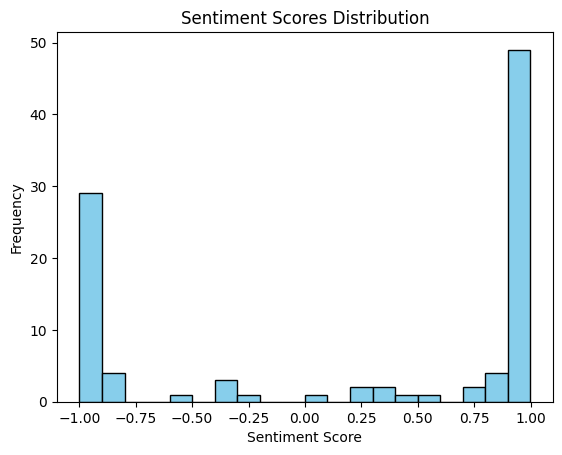

In [7]:
# plot the sentiment scores
plt.hist(sentiment_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Scores Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

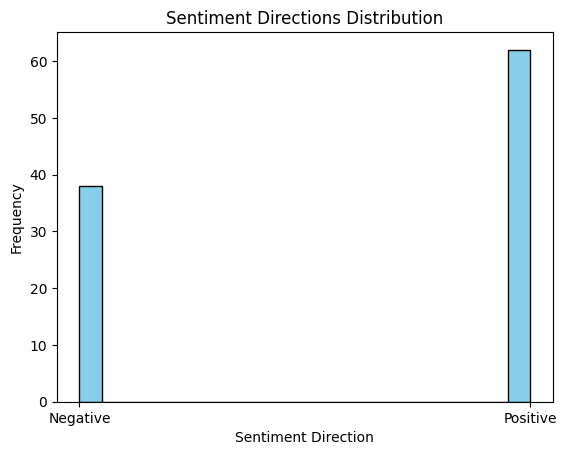

In [8]:
# plot the sentiment directions
plt.hist(sentiment_directions, bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Directions Distribution')
plt.xlabel('Sentiment Direction')
plt.ylabel('Frequency')
plt.show()

### Getting the summary average content length

In [9]:
# Load data from both methods
summary_data = pd.read_csv("apnews_summary.csv")

# Print basic stats
print(f"Summary of {len(summary_data)} articles in {summary_data.shape[0]} rows")

# Compare text lengths (indicating completeness of data)
summary_data["Content Length"] = summary_data["Summary"].str.len()

print("\nAverage Content Length (Summary):", summary_data["Content Length"].mean())

Summary of 100 articles in 100 rows

Average Content Length (Summary): 284.72


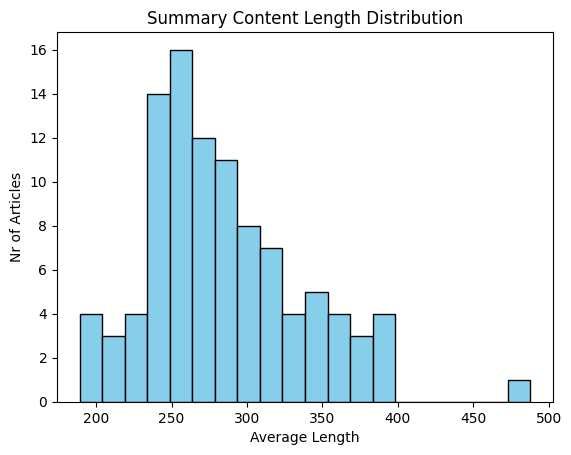

In [10]:
# Plotting the Average content length
plt.hist(summary_data["Content Length"], bins=20, color='skyblue', edgecolor='black')
plt.title('Summary Content Length Distribution')
plt.xlabel('Average Length')
plt.ylabel('Nr of Articles')
plt.show()